# First pass analysis of line/loop data

<ul>
    <li> Analyse correct sequence lengths. </li>
    <li> Do reaction times </li>
    <li> Analyse as a function of distance from reward </li>
    <li> Try to fit RL model to these data </li> 
    
</ul>

<b> WHY IS THERE A DIFFERENCE BETWEEN REW_LIST AND DAT_DICT['STATE'] </b>

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn
import scipy.stats as stt
seaborn.set(font_scale=1.5,style='ticks')
import os
import re
import sys
import itertools
import functools
import networkx as nx
from datetime import date, timedelta
from datetime import datetime

#sys.path.append(r"C:\Users\yweissenberger\Documents\code\line_loop-master")
#sys.path.append(r"C:\Users\yweissenberger\Documents\code\line_loop-master\packages")
sys.path.append("/Users/yves/Documents/Code/line_loop/packages/")

/Users/yves/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
import mouse_poker as mpk

# Defined functions 

In [3]:
poke_pos = [ [149,0],
         [68,19],[231,19],
       [0,62],[149,62],[298,62],
         [68,105],[231,105],
              [149,124]]

In [98]:
lines

['I Experiment name  : line_loop_batch_3NAVI_toLOOP\n',
 'I Task name : YW\\transition_task_yw_growing_navi_big_cohort_line_to_loop\n',
 'I Task file hash : 2965001121\n',
 'I Setup ID : COM4\n',
 "I Subject ID : '456675_10'\n",
 'I Start date : 2021/03/05 12:36:14\n',
 '\n',
 'S {"handle_poke": 1, "reward_consumption": 2, "deliver_reward": 3, "lights_off": 4, "ITI": 5}\n',
 '\n',
 'E {"lights_off_timer": 29, "poke_2_out": 9, "poke_8_out": 21, "repeat_timer": 30, "light_timer": 27, "rew_timer": 26, "poke_3_out": 11, "poke_9": 22, "poke_8": 20, "poke_5_out": 15, "poke_timer": 28, "ITI_timer": 31, "poke_3": 10, "poke_2": 8, "poke_1": 6, "poke_4_out": 13, "poke_6_out": 17, "poke_7": 18, "poke_6": 16, "poke_1_out": 7, "poke_5": 14, "poke_4": 12, "poke_7_out": 19, "poke_9_out": 23, "end_consumption": 24, "session_timer": 25}\n',
 '\n',
 'V 0 task_nr 1\n',
 'V 0 reward_volume 2\n',
 'V 0 click_volume 40\n',
 'V 0 setup_number 5\n',
 "V 0 subject_id '456675_10'\n",
 'V 0 reward_absorbP 0\n',


In [4]:
def get_poke_to_state_map(lines):
    """ """
    tmp = []
    for i,j in zip([int(re.findall('POKEDPORT_([0-9])',i)[0]) for i in lines if '_POKEDPORT' in i],
                         [int(re.findall('POKEDSTATE_([0-9])',i)[0]) for i in lines if '_POKEDSTATE' in i]):

        if [i,j] not in tmp:
            tmp.append([i,j])
    poke_to_state_map = [i[1] for i in sorted(tmp)]
    return poke_to_state_map,tmp

In [5]:
def map_poke_to_state_fun(pkst_map,poke):
    "i[0] are ports i[1] are states"
    tmp1 = [i[0] for i in pkst_map]
    tmp2 = [i[1] for i in pkst_map]
    return tmp2[tmp1.index(poke)]


def map_state_to_poke_fun(pkst_map,poke):
    "i[0] are ports i[1] are states"
    tmp1 = [i[0] for i in pkst_map]
    tmp2 = [i[1] for i in pkst_map]
    return tmp1[tmp2.index(poke)]

In [6]:
def get_performance(dat_dict,map_poke_to_state,rew_indices,lines,minNrew=5):
    
    """ Checked the reward locations """

    used_states = sorted([i[1] for i in map_poke_to_state.args[0]])
    perf = np.zeros([9,9])
    perf_ctr = np.zeros([9,9])
    rew_hist = []
    
    for rew_ctr,(st,nd) in enumerate(zip(np.where(dat_dict['rew_list'])[0][:-1]+1,np.where(dat_dict['rew_list'])[0][1:])):
        #rew_loc = map_poke_to_state(dat_dict['rews'][rew_ctr][0])
        rew_loc = dat_dict['state'][nd][0]
        c_rew_index = rew_indices.index(dat_dict['port'][nd][0])

        if not rew_hist:
            rew_hist.append(rew_loc)
        elif rew_loc==rew_hist[-1]:
            rew_hist.append(rew_loc)
        else:
            rew_hist = []

        if len(rew_hist)>minNrew:
            
            #print(seq_rews)
            has_visited = []

            for pk_ctr in range(st,nd):
                if (len(dat_dict['state'][pk_ctr][1])>1) or (dat_dict['state'][pk_ctr][0]==used_states[0] 
                                                             or dat_dict['state'][pk_ctr][0]==used_states[-1]):
                    
                    d0 = np.abs(dat_dict['state'][pk_ctr][0]-rew_loc)
                    d1 = np.abs(dat_dict['state'][pk_ctr+1][0]-rew_loc)
                    #print(dat_dict['state'][pk_ctr],d1<d0,rew_loc)

                    state = dat_dict['state'][pk_ctr][0]
                    
                    rewarded = dat_dict['rew_list'][pk_ctr]  #if it is rewarded. Offset by 1
                    if state not in has_visited:
                        if rewarded:
                            perf[state,rew_loc] += 1
                            perf_ctr[state,rew_loc] += 1

                        elif d1<d0:
                            perf[state,rew_loc] += 1
                            perf_ctr[state,rew_loc] += 1
                        else:
                            perf[state,rew_loc] += 0
                            perf_ctr[state,rew_loc] += 1
                        has_visited.append(state)
    #print(np.unique(rew_hist))
    
    for i in np.unique(rew_hist):
        perf[i,i] = np.nan
    return perf,perf_ctr

In [34]:
def get_transitions(dat_dict,map_poke_to_state,rew_indices,lines,minNrew=5):
    
    """ Checked the reward locations """

    used_states = sorted([i[1] for i in map_poke_to_state.args[0]])
    perf = np.zeros([9,9,9])
    perf_ctr = np.zeros([9,9,9])
    rew_hist = []
    transition_mtx = np.zeros([9,9,9])
    state_ctr = np.zeros([9,9])

    for rew_ctr,(st,nd) in enumerate(zip(np.where(dat_dict['rew_list'])[0][:-1]+1,np.where(dat_dict['rew_list'])[0][1:])):
        #rew_loc = map_poke_to_state(dat_dict['rews'][rew_ctr][0])
        rew_loc = dat_dict['state'][nd][0]
        c_rew_index = rew_indices.index(dat_dict['port'][nd][0])

        if not rew_hist:
            rew_hist.append(rew_loc)
        elif rew_loc==rew_hist[-1]:
            rew_hist.append(rew_loc)
        else:
            rew_hist = []

        print("rew")
        if len(rew_hist)>minNrew:
            
            for pk_ctr in range(st,nd):
                if ((len(dat_dict['state'][pk_ctr][1])>1)):# or (dat_dict['state'][pk_ctr][0]==used_states[0] 
                                                          #    or dat_dict['state'][pk_ctr][0]==used_states[-1])):
                    
                    state = dat_dict['state'][pk_ctr][0]
                    next_state = dat_dict['state'][pk_ctr+1][0]
                    print(state,next_state)
                    
                    transition_mtx[state,next_state,rew_loc] += 1
                    state_ctr[state,rew_loc] += 1
        
    #transition_mtx = transition_mtx/state_ctr[None,:]         
    return transition_mtx, state_ctr

In [35]:
def run_transition_perf_analysis(lines):
    experiment_name, task_name, subject_id, task_nr, graph,lineloop,date,test,_ = mpk.load.get_metadata(lines)
    dat_dict,events,event_times,nRews,_ = mpk.load.parse_data(lines,experiment_name)
    poke_to_state_map,full_pkst_map = get_poke_to_state_map(lines)
    used_states = sorted([i[1] for i in full_pkst_map])
    used_pokes = ([i[0] for i in full_pkst_map])

    map_poke_to_state = functools.partial(map_poke_to_state_fun,full_pkst_map)
    map_state_to_poke = functools.partial(map_state_to_poke_fun,full_pkst_map)

    #rew_indices = [0,3,5,8]
    rew_indices = np.unique([eval(re.findall('REWARD LOCATIONS(\[.*\])',l)[0]) for l in lines if re.findall('REWARD LOCATIONS(\[.*\])',l)][0]).tolist()
    perf,perf_ctr = get_performance(dat_dict,map_poke_to_state,rew_indices,lines,minNrew=0)
    transition_mtx,ctr = get_transitions(dat_dict,map_poke_to_state,rew_indices,lines,minNrew=0)

    return np.array([(transition_mtx/ctr[:,None])[:,:,i] for i in range(9) if np.nansum((transition_mtx/ctr[:,None])[:,:,i])>0])

In [115]:
f = fdict['456675_10loop'][1]

In [116]:
lines = open(f,'r').readlines()

poke_to_state_map,full_pkst_map = get_poke_to_state_map(lines)
used_states = sorted([i[1] for i in full_pkst_map])
used_pokes = ([i[0] for i in full_pkst_map])

map_poke_to_state = functools.partial(map_poke_to_state_fun,full_pkst_map)
map_state_to_poke = functools.partial(map_state_to_poke_fun,full_pkst_map)
rew_indices = np.unique([eval(re.findall('REWARD LOCATIONS(\[.*\])',l)[0]) for l in lines if re.findall('REWARD LOCATIONS(\[.*\])',l)][0]).tolist()

tmtx = run_transition_perf_analysis(lines)


transition_mtx,ctr = get_transitions(dat_dict,map_poke_to_state,rew_indices,lines,minNrew=0)


rew
5 6
6 5
5 6
6 1
rew
4 5
5 6
6 1
rew
2 1
rew
3 2
2 1
rew
2 3
3 4
4 5
5 6
6 5
5 6
6 1
rew
rew
rew
5 6
6 5
5 6
6 1
rew
2 1
rew
6 1
rew
5 6
6 1
rew
3 2
2 1
rew
4 5
5 6
6 1
rew
4 3
3 2
2 1
rew
4 5
5 6
6 1
rew
2 3
3 2
2 1
rew
5 6
6 1
rew
3 2
2 1
rew
2 3
3 2
2 3
3 2
2 1
rew
4 3
3 4
4 5
5 6
6 1
rew
3 2
2 3
3 4
4 5
5 6
6 1
rew
2 1
rew
4 5
5 6
6 1
rew
2 3
3 2
2 3
3 2
2 1
rew
rew
2 3
3 2
2 1
1 6
6 1
1 6
6 5
rew
rew
1 6
6 1
1 6
6 5
rew
2 1
1 6
6 5
rew
4 5
rew
rew
3 2
2 1
1 6
6 5
rew
4 5
rew
1 2
2 3
3 2
2 1
1 6
6 5
rew
2 3
3 2
2 1
1 6
6 5
rew
2 3
3 2
2 1
1 6
6 5
rew
2 3
3 2
2 3
3 2
2 1
1 6
6 5
rew
6 5
rew
rew
3 2
2 1
1 6
6 5
rew
rew
rew
3 2
2 1
1 6
6 5
rew
rew
3 4
4 5
rew
1 6
6 5
rew
6 5
rew
4 5
rew
rew
2 3
3 2
2 1
1 6
6 5
rew
rew
rew
4 3
rew
2 3
rew
2 3
rew
2 3
rew
rew
2 3
rew
5 4
4 3
rew
rew
4 3
rew
2 3
rew
rew
2 3
rew
2 3
rew
5 4
4 3
rew
rew
4 3
rew
4 3
rew
rew
rew
4 3
rew
rew
5 6
6 5
5 6
6 1
rew
4 5
5 6
6 1
rew
2 1
rew
3 2
2 1
rew
2 3
3 4
4 5
5 6
6 5
5 6
6 1
rew
rew
rew
5 6
6 5
5 6
6 1
rew


/Users/yves/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


(0.5, 6.5)

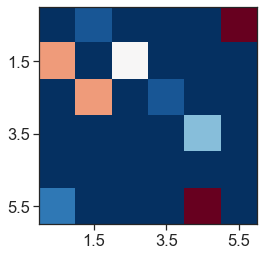

In [118]:
im = plt.imshow(transition_mtx[:,:,5],cmap='RdBu_r')
#plt.xticks(np.arange(centers[0], centers[1]+dx, dx))
#ax = plt.gca()
plt.xticks(plt.xticks()[0],plt.xticks()[0]-.5) 
plt.yticks(plt.yticks()[0],plt.yticks()[0]-.5)

plt.ylim(6.5,.5)
plt.xlim(.5,6.5)

array([0. , 0.2, 0.4, 0.6, 0.8, 1. ])

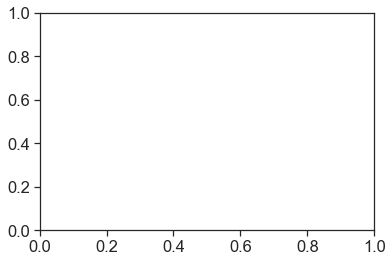

In [64]:
plt.xticks()[0]


In [28]:
transition_mtx.sum(axis=(0,1))

array([ 0., 68.,  0., 16.,  0., 63.,  0.,  0.,  0.])

In [29]:
np.nansum((transition_mtx/ctr[:,None]),axis=(0,1))

/Users/yves/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


array([0., 5., 0., 3., 0., 5., 0., 0., 0.])

# Actual code to run stuff 

In [30]:
ROOT_loop = '/Users/yves/Documents/beh_dat_new_room/line_loop_batch_3NAVI_toLOOP//'
ROOT_line = '/Users/yves/Documents/beh_dat_new_room/line_loop_batch_3NAVI///'
\


In [31]:
fdict = {}

for ROOT,lineloop in zip([ROOT_line,ROOT_loop],['line','loop']):
    fs = os.listdir(ROOT)
    for f in fs:
        f = os.path.join(ROOT,f)

        subject = re.findall("'(.*)'",f)
        if '03-05' in f:
            if subject: 
                lines =open(f,'r').readlines()

                subject = subject[0]
                experiment_name, task_name, subject_id, task_nr, graph,lineloop,date,test,_ = mpk.load.get_metadata(lines)
                dat_dict,events,event_times,nRews,_ = mpk.load.parse_data(lines,experiment_name)
                
                if nRews>20:
                    print(f)
                    if subject+lineloop in fdict.keys():
                        fdict[subject+lineloop].append(f)
                    else:
                        fdict[subject+lineloop] = [f]



/Users/yves/Documents/beh_dat_new_room/line_loop_batch_3NAVI///'460175_10'-2021-03-05-120412.txt
/Users/yves/Documents/beh_dat_new_room/line_loop_batch_3NAVI///'456675_10'-2021-03-05-120412.txt
/Users/yves/Documents/beh_dat_new_room/line_loop_batch_3NAVI///'460175_10'-2021-03-05-125238.txt
/Users/yves/Documents/beh_dat_new_room/line_loop_batch_3NAVI///'456675_10'-2021-03-05-125238.txt
/Users/yves/Documents/beh_dat_new_room/line_loop_batch_3NAVI_toLOOP//'460175_10'-2021-03-05-131715.txt
/Users/yves/Documents/beh_dat_new_room/line_loop_batch_3NAVI_toLOOP//'456675_10'-2021-03-05-131714.txt
/Users/yves/Documents/beh_dat_new_room/line_loop_batch_3NAVI_toLOOP//'460175_10'-2021-03-05-123614.txt
/Users/yves/Documents/beh_dat_new_room/line_loop_batch_3NAVI_toLOOP//'456675_10'-2021-03-05-123614.txt


In [32]:
fdict

{'460175_10line': ["/Users/yves/Documents/beh_dat_new_room/line_loop_batch_3NAVI///'460175_10'-2021-03-05-120412.txt",
  "/Users/yves/Documents/beh_dat_new_room/line_loop_batch_3NAVI///'460175_10'-2021-03-05-125238.txt"],
 '456675_10line': ["/Users/yves/Documents/beh_dat_new_room/line_loop_batch_3NAVI///'456675_10'-2021-03-05-120412.txt",
  "/Users/yves/Documents/beh_dat_new_room/line_loop_batch_3NAVI///'456675_10'-2021-03-05-125238.txt"],
 '460175_10loop': ["/Users/yves/Documents/beh_dat_new_room/line_loop_batch_3NAVI_toLOOP//'460175_10'-2021-03-05-131715.txt",
  "/Users/yves/Documents/beh_dat_new_room/line_loop_batch_3NAVI_toLOOP//'460175_10'-2021-03-05-123614.txt"],
 '456675_10loop': ["/Users/yves/Documents/beh_dat_new_room/line_loop_batch_3NAVI_toLOOP//'456675_10'-2021-03-05-131714.txt",
  "/Users/yves/Documents/beh_dat_new_room/line_loop_batch_3NAVI_toLOOP//'456675_10'-2021-03-05-123614.txt"]}

In [33]:
transition_res = {}
for subject in fdict.keys():

    for f in fdict[subject]:
        print(f)
        lines = open(f,'r').readlines()

        poke_to_state_map,full_pkst_map = get_poke_to_state_map(lines)
        used_states = sorted([i[1] for i in full_pkst_map])
        used_pokes = ([i[0] for i in full_pkst_map])

        map_poke_to_state = functools.partial(map_poke_to_state_fun,full_pkst_map)
        map_state_to_poke = functools.partial(map_state_to_poke_fun,full_pkst_map)
        rew_indices = np.unique([eval(re.findall('REWARD LOCATIONS(\[.*\])',l)[0]) for l in lines if re.findall('REWARD LOCATIONS(\[.*\])',l)][0]).tolist()

        tmtx = run_transition_perf_analysis(lines)
        if subject in transition_res.keys():
            transition_res[subject].append(tmtx)
        else:
            transition_res[subject] = [tmtx]

/Users/yves/Documents/beh_dat_new_room/line_loop_batch_3NAVI///'460175_10'-2021-03-05-120412.txt
2 3
3 2
2 1
2 1
2 1
5 4
4 3
3 2
2 1
4 5
5 4
4 5
5 6
5 4
4 5
5 4
4 3
3 4
4 5
5 4
4 3
3 4
4 5
5 6
5 4
4 3
3 2
2 1
3 4
4 5
5 4
4 5
5 6
5 4
4 3
3 4
4 5
5 6
5 6
5 4
4 3
3 2
2 3
3 2
2 1
4 5
5 6
5 6
5 4
4 3
3 2
2 1
4 3
3 2
2 1
5 4
4 3
3 4
4 3
3 2
2 1
4 5
5 6
5 4
4 3
3 2
2 1
5 4
4 3
3 2
2 1
2 3
3 4
4 5
5 4
4 3
3 2
2 1
2 3
3 2
2 1
5 4
4 3
3 4
4 5
5 4
4 3
3 2
2 1
5 4
4 3
3 4
4 3
3 2
2 1
2 3
3 2
2 1
5 4
4 3
3 4
4 3
3 2
2 1
3 2
2 1
2 1
2 1
2 3
3 2
2 1
2 1
2 1
4 3
3 4
4 3
3 2
2 1
2 1
5 4
4 3
3 2
2 1
3 2
2 1
3 4
4 3
3 4
4 3
3 2
2 1
2 3
3 2
2 1
2 3
3 2
2 1
2 1
2 3
3 2
2 1
2 3
3 2
2 3
3 2
2 3
3 2
2 1
2 3
3 4
4 5
3 4
4 5
2 3
3 2
2 1
2 3
3 2
2 3
3 4
4 3
3 2
2 1
2 3
3 2
2 1
2 3
3 4
4 5
4 5
3 4
4 5
2 3
3 4
4 5
4 3
3 4
4 5
4 5
3 2
2 1
2 3
3 2
2 3
3 2
2 3
3 2
2 3
3 4
4 5
3 2
2 3
3 4
4 5
2 3
3 4
4 5
3 4
4 5
4 5
2 3
3 2
2 3
3 2
2 3
3 2
2 1
2 1
2 3
3 2
2 3
3 2
2 3
3 4
4 5
4 5
2 3
5 6
5 4
4 5
5 6
5 4
4 5
5 6
5 4
4 3

/Users/yves/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


3 4
4 3
3 4
4 5
5 6
5 4
4 3
3 2
2 1
2 3
3 2
2 1
2 3
3 4
4 3
3 4
4 5
5 4
4 3
3 2
2 1
5 4
4 3
3 2
2 1
4 3
3 2
2 1
5 6
5 4
4 3
3 2
2 1
2 3
3 4
4 5
5 6
5 4
4 3
3 2
2 1
4 3
3 2
2 1
4 3
3 2
2 1
2 3
3 4
4 5
5 4
4 3
3 2
2 1
5 4
4 3
3 2
2 1
5 4
4 3
3 4
4 5
5 6
5 4
4 5
5 6
5 6
5 4
4 3
3 4
4 5
5 4
4 3
3 4
4 5
5 6
5 4
4 5
5 6
5 6
5 4
4 3
4 3
3 2
2 3
3 4
4 3
3 4
4 3
3 4
4 5
5 6
5 4
4 3
3 2
2 1
3 2
2 1
4 3
3 2
2 3
3 4
4 3
3 4
4 3
3 2
2 1
2 3
3 2
2 1
2 3
3 4
4 5
5 6
5 4
4 5
5 4
4 3
3 4
4 5
5 6
5 6
5 4
4 5
5 4
4 5
5 4
4 3
3 2
2 1
4 3
3 2
2 1
5 6
5 4
4 3
3 2
2 1
4 5
5 4
4 3
3 4
4 5
5 6
5 4
4 3
3 2
2 1
4 3
3 2
2 1
5 4
4 3
3 2
2 1
3 2
2 1
4 3
3 2
2 3
3 2
2 1
2 3
3 4
4 5
2 3
3 4
4 5
2 3
3 2
2 1
2 3
3 2
2 1
2 3
3 4
4 5
2 3
3 4
4 5
2 3
3 4
4 5
2 3
3 4
4 5
2 3
3 4
4 5
4 3
3 2
2 3
3 4
4 5
4 5
4 5
2 3
3 4
4 5
4 3
3 2
2 3
3 2
2 3
3 4
4 5
4 3
3 4
4 5
3 4
4 5
3 2
2 3
3 2
2 3
3 4
4 3
3 2
2 1
2 3
3 4
4 5
4 3
4 3
5 4
4 3
5 4
4 3
4 3
2 3
2 3
2 3
5 4
4 3
/Users/yves/Documents/beh_dat_new_room/line_loop_batch_3NAVI///'

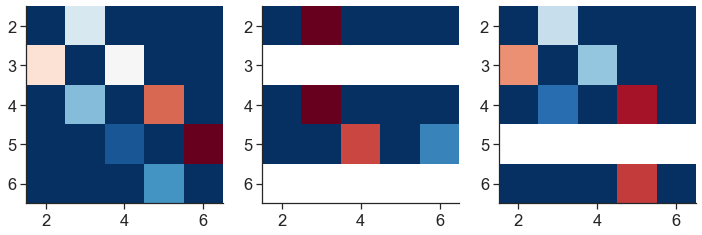

In [127]:
plt.figure(figsize=(12,4))
for ix,im in enumerate(np.array(transition_res[subject]).mean(axis=0)):
    plt.subplot(1,3,ix+1)
    plt.imshow(im,cmap='RdBu_r')
    plt.xlim(1.5,6.5)
    plt.ylim(6.5,1.5)
    
seaborn.despine()

5


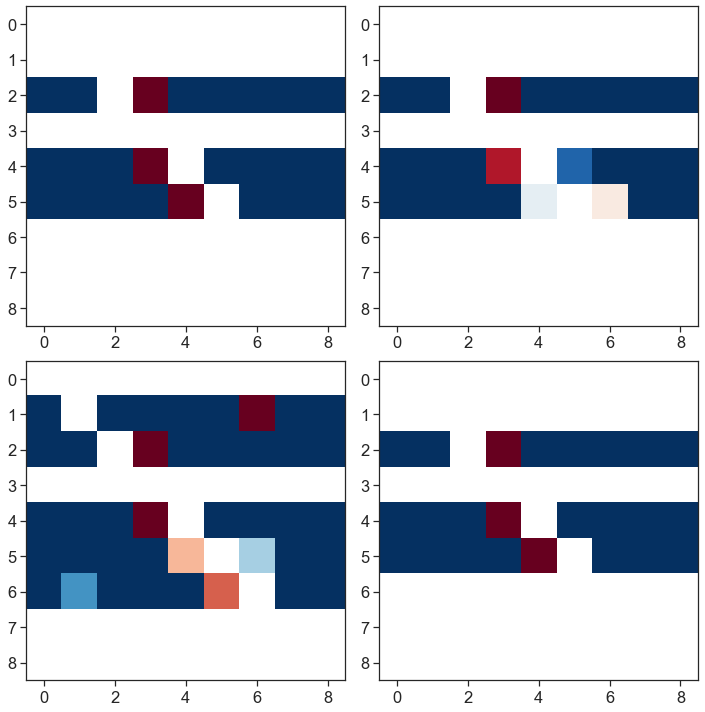

In [128]:
perf = np.zeros(tmtx.shape[-2:])
rew_diag_mtx = np.dstack([np.eye(perf.shape[0])*-1 + 1]*3 + [np.eye(perf.shape[0])])


print(map_poke_to_state(rew_indices[0]))

rew_loc = 1
base_subject = '456675_10'
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
pf_ = transition_res[base_subject+'line'][0][rew_loc]
np.fill_diagonal(pf_,np.nan)
plt.imshow(pf_,cmap='RdBu_r',vmin=0,vmax=1)

#offmtx = transition_res['460175_10line'][0]>0
plt.subplot(2,2,2)
pf_ = transition_res[base_subject+'line'][1][rew_loc]
np.fill_diagonal(pf_,np.nan)
plt.imshow(pf_,cmap='RdBu_r',vmin=0,vmax=1)


plt.subplot(2,2,3)
pf_ = transition_res[base_subject+'loop'][0][rew_loc]
np.fill_diagonal(pf_,np.nan)
plt.imshow(pf_,cmap='RdBu_r',vmin=0,vmax=1)

plt.subplot(2,2,4)
pf_ = transition_res[base_subject+'loop'][1][rew_loc]
np.fill_diagonal(pf_,np.nan)
plt.imshow(pf_,cmap='RdBu_r',vmin=0,vmax=1)
plt.tight_layout()

In [ ]:
def run_transition_perf_analysis(lines):
    experiment_name, task_name, subject_id, task_nr, graph,lineloop,date,test,_ = mpk.load.get_metadata(lines)
    dat_dict,events,event_times,nRews,_ = mpk.load.parse_data(lines,experiment_name)
    poke_to_state_map,full_pkst_map = get_poke_to_state_map(lines)
    used_states = sorted([i[1] for i in full_pkst_map])
    used_pokes = ([i[0] for i in full_pkst_map])

    map_poke_to_state = functools.partial(map_poke_to_state_fun,full_pkst_map)
    map_state_to_poke = functools.partial(map_state_to_poke_fun,full_pkst_map)

    #rew_indices = [0,3,5,8]
    rew_indices = np.unique([eval(re.findall('REWARD LOCATIONS(\[.*\])',l)[0]) for l in lines if re.findall('REWARD LOCATIONS(\[.*\])',l)][0]).tolist()
    perf,perf_ctr = get_performance(dat_dict,map_poke_to_state,rew_indices,lines,minNrew=0)
    transition_mtx,ctr = get_transitions(dat_dict,map_poke_to_state,rew_indices,lines,minNrew=0)

    return (transition_mtx/ctr[:,None])

In [ ]:
perf,perf_ctr = get_performance(dat_dict,map_poke_to_state,rew_indices,lines,minNrew=0)
transition_mtx,ctr = get_transitions(dat_dict,map_poke_to_state,rew_indices,lines,minNrew=0)


In [ ]:
transition_mtx[4]

In [ ]:
(transition_mtx/ctr[:,None])[4].sum()

In [ ]:
plt.imshow(transition_mtx/ctr[:,None],cmap='RdBu_r')
plt.colorbar()


In [ ]:
#print(day_df['filepath'].values[ix])
#f = open("/Users/yves/Documents/behavior_data/line_loop_cohort_1/line_loop_batch_4_RUNNAVI/'456675_3'-2020-12-09-094620.txt",'r')
#f = open("/Volumes/hpc_dat/pycontrol/data/line_loop_batch_4_RUNNAVI/'456675_3'-2021-02-12-121633.txt",'r')
#f = open("/Users/yves/Documents/beh_dat_new_room/line_loop_batch_3NAVI/",'r')
#f = open("C:/Users/yweissenberger/Documents/pycontrol_newest_10_02_21/data/line_loop_batch_3NAVI/'456675_10'-2021-03-04-105905.txt",'r')
#f =open("C:/Users/yweissenberger/Documents/pycontrol_newest_10_02_21/data/line_loop_batch_3NAVI_toLOOP/'460175_10'-2021-03-04-154221.txt",'r')
lines =f.readlines()
experiment_name, task_name, subject_id, task_nr, graph,lineloop,date,test,_ = mpk.load.get_metadata(lines)
dat_dict,events,event_times,nRews,_ = mpk.load.parse_data(lines,experiment_name)

print("rewards_received: {:d}".format(nRews))
print('task_nr:{:.0f}'.format(int(task_nr)))

In [ ]:
state_seq = [i[0] for i in dat_dict['state']]
poke_seq = [map_state_to_poke(i) for i in state_seq]
#dat_dict['rews']

In [ ]:
poke_to_state_map,full_pkst_map = get_poke_to_state_map(lines)
used_states = sorted([i[1] for i in full_pkst_map])
used_pokes = ([i[0] for i in full_pkst_map])

map_poke_to_state = functools.partial(map_poke_to_state_fun,full_pkst_map)
map_state_to_poke = functools.partial(map_state_to_poke_fun,full_pkst_map)

#rew_indices = [0,3,5,8]
rew_indices = np.unique([eval(re.findall('REWARD LOCATIONS(\[.*\])',l)[0]) for l in lines if re.findall('REWARD LOCATIONS(\[.*\])',l)][0]).tolist()


In [ ]:
print(task_nr)

In [ ]:
perf

In [ ]:
perf,perf_ctr = get_performance(dat_dict,map_poke_to_state,rew_indices,lines,minNrew=0)
fc = perf/perf_ctr
#fc[np.isnan(fc)] = 1
print(np.nanmean(fc))

In [ ]:
np.nansum(perf)/np.nansum(perf_ctr)

In [ ]:
perf

In [ ]:
plt.title('Each column is one reward location')
rew_diag_mtx = np.dstack([np.eye(perf.shape[0])*-1 + 1]*3 + [np.eye(perf.shape[0])])
fcplot = (perf/perf_ctr)
np.fill_diagonal(fcplot,np.nan)
plt.imshow(rew_diag_mtx,cmap='Greys')
plt.imshow(fcplot,vmin=0,vmax=1,cmap='RdBu_r')
#plt.xlim(.5,6.5); plt.ylim(6.5,.5)
plt.colorbar()

# Run as batch analysis the above 

In [ ]:
now = datetime.now()

In [ ]:
ROOT = "C:/Users/yweissenberger/Documents/pycontrol_newest_10_02_21/data/line_loop_batch_3NAVI/"
fs = os.listdir(ROOT)
res_dict = {}
minNRew = 10
today = datetime.now()
for f_ in fs:
        
    fpath = os.path.join(ROOT,f_)
    if os.path.isfile(fpath):
        subject = eval(re.findall("('.*')",f_)[0])
        #print(subject)

        t1_ = re.findall(r'(202.*)-[0-9]{6}.txt',f_)[0]
        t1_ = datetime.strptime(t1_,'%Y-%m-%d')
        
        if (now - t1_).days<=2:
            f = open(fpath,'r')

            lines =f.readlines()
            experiment_name, task_name, subject_id, task_nr, graph,lineloop,date,test,_ = mpk.load.get_metadata(lines)
            dat_dict,events,event_times,nRews,_ = mpk.load.parse_data(lines,experiment_name)
            subject = subject + '_' + str(task_nr)
            print(task_nr,fpath)
            if nRews>20:

                poke_to_state_map,full_pkst_map = get_poke_to_state_map(lines)
                used_states = sorted([i[1] for i in full_pkst_map])
                used_pokes = ([i[0] for i in full_pkst_map])

                map_poke_to_state = functools.partial(map_poke_to_state_fun,full_pkst_map)
                map_state_to_poke = functools.partial(map_state_to_poke_fun,full_pkst_map)

                #rew_indices = [0,3,5,8]
                rew_indices = np.unique([eval(re.findall('REWARD LOCATIONS(\[.*\])',l)[0]) for l in lines if re.findall('REWARD LOCATIONS(\[.*\])',l)][0]).tolist()
                perf,perf_ctr = get_performance(dat_dict,map_poke_to_state,rew_indices,lines,minNrew=minNRew)

                if subject not in res_dict.keys():
                    res_dict[subject] = [[perf,perf_ctr]]
                else:
                    res_dict[subject].append([perf,perf_ctr])


In [ ]:
plt.figure(figsize=(10,8))
for ctr,subject in enumerate(res_dict.keys()):
    
    plt.subplot(2,2,ctr+1)
    plt.title("Subject: {} | Graph: {}".format(subject[:-2],subject[-1]))
    allp = np.nansum([i[0] for i in res_dict[subject]],axis=0)
    allp_ctr = np.nansum([i[1] for i in res_dict[subject]],axis=0)
    fc = (allp/allp_ctr)
    np.fill_diagonal(fc,np.nan)
    plt.imshow(np.dstack([np.eye(perf.shape[0])*-1 + 1]*3 + [np.eye(perf.shape[0])]),cmap='Greys')
    plt.imshow(fc,vmin=0,vmax=1,cmap='RdBu_r')
    
    if ctr==0:
        plt.xlabel("Rewarded State")
        plt.ylabel("Current State")
        cbar = plt.colorbar()
        cbar.set_label("Fraction correct")

plt.tight_layout()

# Other

In [ ]:
st = np.min(np.where(np.nansum(perf,axis=1))[0]) - 1
nd = np.max((np.where(np.nansum(perf,axis=1))[0])) + 1


#these are the pokes used for reward in this session
used_rews = np.array([np.where(np.isnan(perf[:,i]))[0] for i in np.where(np.nansum(perf,axis=0))[0]]).flatten()
used_rew_cols = np.where(np.nansum(perf,axis=0))[0]

In [ ]:
ix = used_rew_cols[0]
c_rew_index = ix

#good_edges = [[map_state_to_poke(0),map_state_to_poke(1)],
#              [map_state_to_poke(8),map_state_to_poke(7)]]
bad_edges = []
good_edges = []
for s in range(st-1,nd+1):
    if s!=c_rew_index and s in used_states:
        d1 = np.abs(c_rew_index-(s+1))  #distances of state above to reward
        d2 = np.abs(c_rew_index-(s-1))  #distance of state below to reward
        min_ = np.argmin([d1,d2])
        max_ = np.argmax([d1,d2])
        
        if [s+1,s-1][min_] in used_states:
            good_edges.append([s,[s+1,s-1][min_]])  #good edges in terms of pokes
        
        if [s+1,s-1][max_] in used_states:
            bad_edges.append([s,[s+1,s-1][max_]])   #bad edges in terms of pokes

In [ ]:
map_state_to_poke(ix)

In [ ]:
used_rew_cols

In [ ]:
#rew_indices = [0,1,4,5]

In [ ]:
st = np.min(np.where(np.nansum(perf,axis=1))[0]) - 1
nd = np.max((np.where(np.nansum(perf,axis=1))[0])) + 1


#these are the pokes used for reward in this session
used_rews = np.array([np.where(np.isnan(perf[:,i]))[0] for i in np.where(np.nansum(perf,axis=0))[0]]).flatten()
used_rew_cols = np.where(np.nansum(perf,axis=0))[0]

In [ ]:
nd

In [ ]:
plt.figure(figsize=(18,4))
ctr = 1
for ix in used_rew_cols:
    plt.subplot(1,len(used_rew_cols),ctr)

    c_rew_index = ix  #this is correct, used_rews here are in terms of states

    bad_edges = []
    good_edges = []
    same_edges = []
    good_edges = [[map_state_to_poke(used_states[0]),map_state_to_poke(used_states[1])],
                  [map_state_to_poke(used_states[-1]),map_state_to_poke(used_states[-2])]]

    for s in range(st-2,nd+2):
        if s!=c_rew_index and s in used_states:
            su = s+1 #state_up
            sd = s-1 #state_down
            if lineloop=='loop': 
                if su==used_states[-1]+1:
                    su= used_states[0]
                if sd==used_states[0]-1:
                    sd = used_states[-1]
            d1 = np.abs(c_rew_index-(su))  #distances of state above to reward
            d2 = np.abs(c_rew_index-(sd))  #distance of state below to reward
            
            if d1==d2:
                if mn_ in used_states:
                    good_edges.append([map_state_to_poke(s),map_state_to_poke(mn_)])

                if mx_ in used_states:
                    bad_edges.append([map_state_to_poke(s),map_state_to_poke(mx_)])

            else:
                
                min_ = np.argmin([d1,d2])
                max_ = np.argmax([d1,d2])

                mn_ = [su,sd][min_]; mx_ = [su,sd][max_]
                if mn_ in used_states:
                    good_edges.append([map_state_to_poke(s),map_state_to_poke(mn_)])

                if mx_ in used_states:
                    bad_edges.append([map_state_to_poke(s),map_state_to_poke(mx_)])

                

    pos = np.array([1,-1])*poke_pos
    G0 = nx.DiGraph()
    G0.add_nodes_from(range(9),pos=np.array([1,-1])*poke_pos)
    nx.draw(G0,pos=pos,alpha=.2)
    G = nx.DiGraph()
    G.add_nodes_from(sorted(used_pokes))
    weights = []
    
    rew_col = fc[:,ix]
    
    for e in good_edges:
        G.add_edge(e[0],e[1],weight=rew_col[map_poke_to_state(e[0])],color='g')

    for e in bad_edges:
        G.add_edge(e[0],e[1],weight=1-rew_col[map_poke_to_state(e[0])],color='r')

    weights = nx.get_edge_attributes(G,'weight')
    colors = nx.get_edge_attributes(G,'color')
    node_colors = ['.3' for _ in range(len(used_states))]
    
    node_colors[list(G.nodes).index(map_state_to_poke(c_rew_index))] = 'g'
    #node_colors[0] = 'g'
    nx.draw(G,
        pos=pos,
            width=(10**(np.array(list(weights.values()))))/2,
            edge_color=np.array(list(colors.values())),
            connectionstyle="arc3,rad=-0.1",
            node_color=node_colors,
            node_size=768)
    #print(G.node)
    ctr += 1
plt.tight_layout()
#plt.savefig("/Users/yves/Desktop/tpf/navi_decisions.svg")
#plt.savefig("/Users/yves/Desktop/tpf/navi_decisions.png",dpi=300)


In [ ]:
map_state_to_poke(c_rew_index)

In [ ]:
list(G.node)

In [ ]:
ix

In [ ]:
fc.shape

In [ ]:
map_state_to_poke(used_rews[ix])

In [ ]:
fc[:,0]

In [ ]:
fc.shape

In [ ]:
us

In [ ]:
used_rews[ix]

In [ ]:
used_states

In [ ]:
used_pokes

In [ ]:
len(used_states)

In [ ]:
len(node_colors)

In [ ]:
nx.draw(G,pos=pos,
        width=(10**(np.array(list(weights.values()))))/2
        
       )


In [ ]:
good_edges

In [ ]:
bad_edges

In [ ]:
pos

In [ ]:
weights

In [ ]:
e[0]

In [ ]:
sqr = fc
sqr[0] = 1
sqr[-1] = 1
plt.imshow(sqr,vmin=0,vmax=1,cmap='RdBu_r')
plt.xlabel("Rew Location")
plt.xticks([0,1,2,3],['T','L','R','B'])
plt.ylabel("State")
cbar = plt.colorbar()
cbar.set_label("Fraction Correct")
plt.tight_layout()

In [ ]:
fc = perf/perf_ctr
fc[np.isnan(fc)] = 1

In [ ]:
fc

# Performance history

In [ ]:
ROOT = '/Users/yves/Documents/behavior_data/line_loop_cohort_1/line_loop_batch_4_RUNNAVI/'
fs = sorted([os.path.join(ROOT,i) for i in os.listdir(ROOT) if '.txt' in i])
perf_hist = []
all_fc  = []
all_perf = np.zeros([9,4])
all_ctr = np.zeros([9,4])
for f_ in fs[:-1]:
    try:
        f = open(f_,'r')
        lines =f.readlines()
        experiment_name, task_name, subject_id, task_nr, graph,lineloop,date,test,_ = mpk.load.get_metadata(lines)
        dat_dict,events,event_times,nRews,_ = mpk.load.parse_data(lines,experiment_name)

        #poke_to_state_map = get_poke_to_state_map(lines)
        rew_indices = [0,3,5,8]
        perf,perf_ctr = get_performance(dat_dict,poke_to_state_map,rew_indices,lines,minNrew=20)

        fc = perf/perf_ctr
        all_perf += perf
        all_ctr += perf_ctr
        all_fc.append(fc)
        perf_hist.append(np.nanmean(fc))
    except:
        pass

In [ ]:
all_perf/all_ctr

In [ ]:
stt.binom_test(0.57*400,n=400)

In [ ]:
fc

In [ ]:
#np.nanmean(all_fc[-5:],axis=0)

In [ ]:
#sqr = all_perf/all_ctr
sqr = np.nanmean(all_fc[-10:],axis=0)
fc = sqr
sqr[0] = 1
sqr[-1] = 1
plt.imshow(sqr,vmin=0,vmax=1,cmap='RdBu_r',aspect=.7)
plt.xlabel("Rew Location")
plt.xticks([0,1,2,3],['T','L','R','B'])
plt.ylabel("State")
cbar = plt.colorbar()
cbar.set_label("Fraction Correct")
#cbar.ax.
plt.tight_layout()
#plt.tight_layout*
#plt.savefig("/Users/yves/Desktop/tpf/navi_frac_corr_by_state.svg")
#plt.savefig("/Users/yves/Desktop/tpf/navi_frac_corr_by_state.png",dpi=300)
print(sqr)

In [ ]:
seaborn.set(font_scale=1.5,style='ticks',rc={'axes.edgecolor': 'k',
                                             'axes.linewidth': 2,
                                             #'xtick.major.size': 6,
                                             'axes.labelcolor':'k',
                                             'xtick.major.width': 2,
                                             'ytick.major.width': 2,
                                             'xtick.major.pad': 5.5,
                                             'ytick.major.pad': 5.5,
                                             'axes.labelsize': 18
                                            })


In [ ]:
from scipy.ndimage import gaussian_filter1d

In [ ]:
sess_perf = [np.nanmean(i) for i in perf_hist if not np.isnan(np.nanmean(i))][1:]
plt.plot(gaussian_filter1d(sess_perf,2.25,mode='nearest'),linewidth=5)
plt.scatter(range(len(sess_perf)),sess_perf,color='k',s=128,edgecolors='none')
plt.xlabel("Session #")
plt.ylabel("Proportion of\n correct transitions")
#plt.xlim(-.5)
seaborn.despine()
plt.tight_layout()
#plt.savefig("/Users/yves/Desktop/tpf/navi_learning.svg")
#plt.savefig("/Users/yves/Desktop/tpf/navi_learning.png",dpi=300)


In [ ]:
sess_perf = [np.nanmean(i) for i in perf_hist if not np.isnan(np.nanmean(i))][1:]
plt.plot(gaussian_filter1d(sess_perf,2.25,mode='nearest'),linewidth=5)
plt.scatter(range(len(sess_perf)),sess_perf,color='k',s=128,edgecolors='none')
plt.xlabel("Session #")
plt.ylabel("Proportion\n correct")
#plt.xlim(-.5)
seaborn.despine()
plt.tight_layout()

In [ ]:
sess_perf = [np.nanmean(i) for i in perf_hist if not np.isnan(np.nanmean(i))][2:]
plt.plot(gaussian_filter1d(sess_perf,1.5),linewidth=3)
plt.scatter(range(len(sess_perf)),sess_perf,color='k',s=96)
plt.xlabel("Session #")
plt.ylabel("Proportion correct transitions")
seaborn.despine()
plt.tight_layout()

In [ ]:
sess_perf